In [3]:
import sys, os, natsort, glob

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch, datasets
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision
import torch.nn.functional as F
from PIL import Image

import mediapipe as mp
import utils
import LantentNet
cudnn.enabled = True

gpu = 0 # GPU ID

#Initialize Model
model = LantentNet.LantentNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
#saved_state_dict = torch.load('models\Latent_model_0.pkl')
#saved_state_dict = torch.load('models\Latent_model_0,5.pkl')
#saved_state_dict = torch.load('models\Latent_model_0,990.pkl')
saved_state_dict = torch.load('models\Latent_model_0,999.pkl') #For best yaw results
#saved_state_dict = torch.load('models\Latent_model_1.pkl')
model.load_state_dict(saved_state_dict)




#Classification and Regression losses
criterion = nn.CrossEntropyLoss().cuda(gpu)
reg_criterion = nn.MSELoss().cuda(gpu)


MAE = torch.nn.L1Loss(reduction='mean')


softmax = nn.Softmax().cuda(gpu)

#For classification vector
idx_tensor = [idx for idx in range(66)]
idx_tensor = Variable(torch.FloatTensor(idx_tensor)).cuda(gpu)


model.cuda(gpu)
model.eval() #Inference mode

print("done")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# 300W-LP DATASETS

In [2]:
image_path = natsort.natsorted(glob.glob('datasets\300W-LP_Full\*.jpg'),reverse= False)
image_path = natsort.natsorted(glob.glob('datasets\Data_Ocluded_300WLP_FULL_25_2\*.jpg'),reverse= False)

transformations = transforms.Compose([transforms.Resize(240), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

d_mat1 =  natsort.natsorted(glob.glob('datasets\300W-LP\300W_LP\AFW\*.mat'),reverse= False) 
d_mat2 = natsort.natsorted(glob.glob('datasets\300W-LP\300W_LP\HELEN\*.mat'),reverse= False) 
d_mat3 = natsort.natsorted(glob.glob('datasets\300W-LP\300W_LP\IBUG\*.mat'),reverse= False) 
d_mat4 = natsort.natsorted(glob.glob('datasets\300W-LP\300W_LP\LFPW\*.mat'),reverse= False)

pose_path = d_mat1+d_mat2+d_mat3+d_mat4


pose_dataset = datasets.o_new_Pose_300W_LP_test(image_path, pose_path, transformations)

batch_size = 1
test_loader = torch.utils.data.DataLoader(dataset=pose_dataset,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=0)

print(len(image_path))
print('done')

61225
done


# BIWI DATASETS

In [ ]:
image_path = natsort.natsorted(glob.glob('datasets\faces_biwi_wide_oclusion\*.jpg'),reverse= False)
image_path = natsort.natsorted(glob.glob('datasets\faces_biwi_wide\*.jpg'),reverse= False)


pose_path = natsort.natsorted(glob.glob('datasets\faces_biwi\01\*.txt'),reverse= False) + natsort.natsorted(glob.glob('datasets\faces_biwi\02\*.txt'),reverse= False) + natsort.natsorted(glob.glob('datasets\faces_biwi\03\*.txt'),reverse= False) + natsort.natsorted(glob.glob('datasets\faces_biwi\04\*.txt'),reverse= False)+ natsort.natsorted(glob.glob('datasets\faces_biwi\05\*.txt'),reverse= False)


transformations = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])



biwi_test_dataset = datasets.new_BIWI(image_path,pose_path, transformations)


test_loader = torch.utils.data.DataLoader(dataset=biwi_test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)
print(len(image_path))
print('done')

# AFLW2000 DATASETS

In [4]:
image_path = natsort.natsorted(glob.glob('datasets\AFLW2000_3D_Full_Faces\*.jpg'))
image_path = natsort.natsorted(glob.glob('datasets\Data_Ocluded_AFLW2000_Full_Faces\*.jpg'))

pose_path = natsort.natsorted(glob.glob('datasets\AFLW2000-3D\AFLW2000\*.mat'))

transformations =  transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_dataset = datasets.new_Pose_AFLW2000(image_path, pose_path, transformations)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False, num_workers=0)
print(len(image_path))
print('done')

2000
done


# TEST DATASET

In [ ]:
MAE_LATENT_y = np.array([])
MAE_LATENT_p = np.array([])
MAE_LATENT_r = np.array([])


num_epochs = 1
with torch.no_grad():
    for i, (img, labels, cont_labels) in enumerate(test_loader):

        img = Variable(img).cuda(gpu)

        label_yaw_cont = Variable(cont_labels[:,0]).cuda(gpu)
        label_pitch_cont = Variable(cont_labels[:,1]).cuda(gpu)
        label_roll_cont = Variable(cont_labels[:,2]).cuda(gpu)
      
        x, yaw, pitch, roll = model(img)

        yaw_predicted = softmax(yaw)#,dim = 1)
        pitch_predicted = softmax(pitch)#,dim = 1)
        roll_predicted = softmax(roll)#,dim =1)

        yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1) * 3 - 99
        pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1) * 3 - 99
        roll_predicted = torch.sum(roll_predicted * idx_tensor, 1) * 3 - 99

        yaw_predicted = yaw_predicted.view(1)
        pitch_predicted = pitch_predicted.view(1)
        roll_predicted = roll_predicted.view(1)

        err_y = MAE(yaw_predicted,label_yaw_cont)
        err_p = MAE(pitch_predicted,label_pitch_cont)
        err_r = MAE(roll_predicted,label_roll_cont)

        MAE_LATENT_y = np.append(MAE_LATENT_y,err_y.cpu())
        MAE_LATENT_p = np.append(MAE_LATENT_p,err_p.cpu())
        MAE_LATENT_r = np.append(MAE_LATENT_r,err_r.cpu())

        if (i%1000 == 0):
            print(i)


In [ ]:
print('MAE ERROR LATENT:')
print('Yaw: ',sum(MAE_LATENT_y)/len(MAE_LATENT_y), ' Pitch: ',sum(MAE_LATENT_p)/len(MAE_LATENT_y), ' Roll: ',sum(MAE_LATENT_r)/len(MAE_LATENT_y))

# INFERENCE FOR INDIVIDUAL FACE IMAGES

In [6]:
#input face image 
img = Image.open('datasets/300W-LP_Full/face0.jpg')
frame = cv2.imread('datasets/300W-LP_Full/face0.jpg')
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

transformations = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

image = transformations(img)


image = image.view(1, 3, 224, 224) 
image = Variable(image).cuda(gpu)
x, yaw, pitch, roll = model(image)

yaw_predicted = softmax(yaw)#,dim = 1)
pitch_predicted = softmax(pitch)#,dim = 1)
roll_predicted = softmax(roll)#,dim =1)

yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1) * 3 - 99
pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1) * 3 - 99
roll_predicted = torch.sum(roll_predicted * idx_tensor, 1) * 3 - 99

yaw_predicted = yaw_predicted.view(1)
pitch_predicted = pitch_predicted.view(1)
roll_predicted = roll_predicted.view(1)

C:\Users\gonca\AppData\Local\Temp\ipykernel_27360\3735495076.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yaw_predicted = softmax(yaw)#,dim = 1)
C:\Users\gonca\AppData\Local\Temp\ipykernel_27360\3735495076.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pitch_predicted = softmax(pitch)#,dim = 1)
C:\Users\gonca\AppData\Local\Temp\ipykernel_27360\3735495076.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  roll_predicted = softmax(roll)#,dim =1)


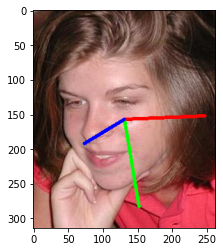

In [7]:
import matplotlib.pyplot as plt
import utils

#Visualize result
utils.draw_axis(frame, yaw_predicted, pitch_predicted, roll_predicted, tdx = frame.shape[1] / 2, tdy= frame.shape[0] / 2, size = frame.shape[1]/2)

plt.figure()
plt.imshow(frame)

# INFERENCE FOR INDIVIDUAL IMAGES WITH FACE DETECTION

In [ ]:
import mediapipe as mp

mpFaceDetection = mp.solutions.face_detection
mpDraw = mp.solutions.drawing_utils
faceDetection = mpFaceDetection.FaceDetection(min_detection_confidence=0.5) #0.65


#input face image 
#img = Image.open('occlusion.jpg')
#frame = cv2.imread('occlusion.jpg')
img = Image.open('datasets\wheel2.jpg')
frame = cv2.imread('wheel2.jpg')
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

results = faceDetection.process(frame)

detection = results.detections[0]

xmin = detection.location_data.relative_bounding_box.xmin
xmax = xmin + detection.location_data.relative_bounding_box.width
ymin = detection.location_data.relative_bounding_box.ymin
ymax = ymin + detection.location_data.relative_bounding_box.height

height = frame.shape[0]
width = frame.shape[1]

bbox_height = ymax-ymin

imgRGB = Image.fromarray(frame)

xmin_new = xmin*width 
ymin_new = ymin*height
xmax_new = xmax*width
ymax_new = ymax*height

# widen the face box margin for better pose estimation
xmin_new = xmin_new - 10
ymin_new = ymin_new - 20 
xmax_new = xmax_new + 10
ymax_new = ymax_new + 15

image = imgRGB.crop((xmin_new, ymin_new ,xmax_new, ymax_new))

transformations = transforms.Compose([transforms.Resize(224), transforms.CenterCrop(224), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

image = transformations(img)


image = image.view(1, 3, 224, 224) 
image = Variable(image).cuda(gpu)
x, yaw, pitch, roll = model(image)

yaw_predicted = softmax(yaw)#,dim = 1)
pitch_predicted = softmax(pitch)#,dim = 1)
roll_predicted = softmax(roll)#,dim =1)

yaw_predicted = torch.sum(yaw_predicted * idx_tensor, 1) * 3 - 99
pitch_predicted = torch.sum(pitch_predicted * idx_tensor, 1) * 3 - 99
roll_predicted = torch.sum(roll_predicted * idx_tensor, 1) * 3 - 99

yaw_predicted = yaw_predicted.view(1)
pitch_predicted = pitch_predicted.view(1)
roll_predicted = roll_predicted.view(1)


In [ ]:
import matplotlib.pyplot as plt
import utils

#Visualize result
utils.draw_axis(frame, yaw_predicted, pitch_predicted, roll_predicted, tdx = frame.shape[1] / 2, tdy= frame.shape[0] / 2, size = frame.shape[1]/2)

plt.figure()
plt.imshow(frame)